In [372]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pycaret

In [ ]:
!pip install catboost

In [373]:
import pandas as pd
import os
from pycaret.regression import *
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler

import matplotlib.pyplot as plt
import matplotlib

import platform
if platform.system() == 'Windows': 
    matplotlib.rc('font', family='Malgun Gothic') 
elif platform.system() == 'Darwin': # Mac 
    matplotlib.rc('font', family='AppleGothic') 
else:
    matplotlib.rc('font', family='NanumGothic')
matplotlib.rcParams['axes.unicode_minus'] = False
matplotlib.style.use('ggplot')

In [374]:
path = '/content/drive/MyDrive/bigcon/emd_model'
file_list = os.listdir(path)
file_list_py = [path+'/'+file[:-4] for file in file_list if file.endswith('.pkl')]

In [375]:
train_df = pd.read_csv('/content/drive/MyDrive/bigcon/final_final_train_0913.csv',index_col=0)
emd_name = '건입동'

df = train_df[train_df['emd_nm'] == emd_name].set_index('base_date')
df.drop(columns=['emd_nm'],inplace=True)
df_dates = df.index
scaler = RobustScaler()

y = df[['em_g']].reset_index(drop=True) # target 컬럼 스케일링 처리하지 않음
scale_cols = df.columns[1:]

scaled = scaler.fit_transform(df[scale_cols])
df = pd.DataFrame(scaled, columns=scale_cols)
df = df.reset_index()

In [376]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(df, y, test_size=0.2, random_state=0, shuffle=False)

In [377]:
model = load_model(file_list_py[0])

Transformation Pipeline and Model Successfully Loaded


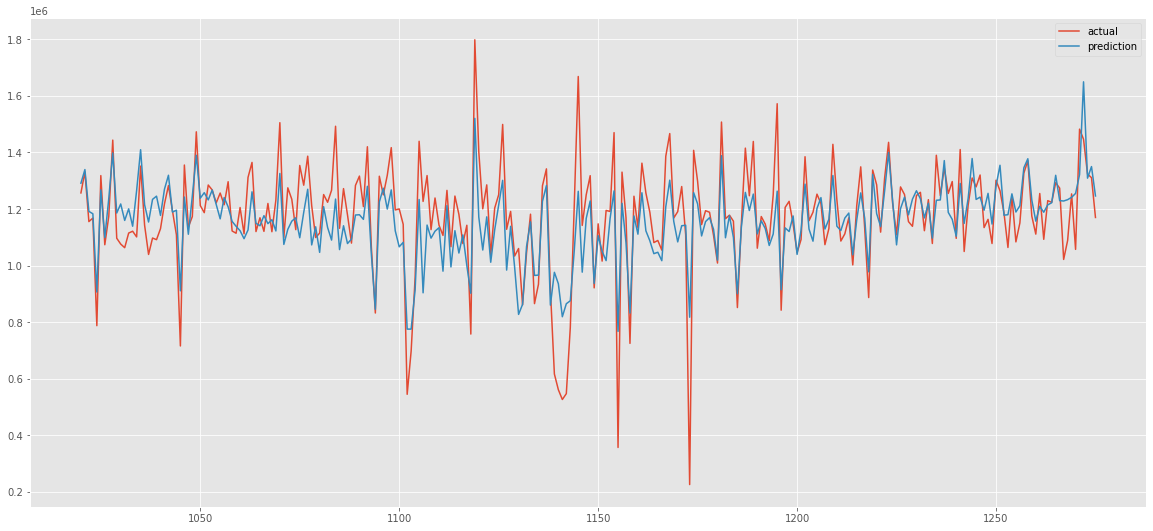

In [378]:
plt.figure(figsize=(20, 9))
plt.plot(y_val, label='actual')
plt.plot(predict_model(model, data = X_val)['Label'], label='prediction')
plt.legend()
plt.show()

In [379]:
test_df = pd.read_csv('/content/drive/MyDrive/bigcon/arimadata.csv',index_col=0).reset_index(drop=True)

In [384]:
def predict_jeju_ver1(dong_name, model):
  emd_name = dong_name
  #model = load_model(model_path[0])
  data = test_df[test_df['emd_nm'] == emd_name].set_index('base_date')
  data.drop(columns=['emd_nm'],inplace=True)

  scale_cols = data.columns
  scaled = scaler.fit_transform(data[scale_cols])

  data = pd.DataFrame(scaled, columns=scale_cols)
  data = data.reset_index()
  return predict_model(model, data = data)['Label']

In [385]:
emd_lst = ['전체', '건입동', '남원읍', '노형동', '대륜동', '대정읍', '대천동', '도두동', '동홍동',
       '봉개동', '삼도1동', '삼도2동', '삼양동', '서홍동', '성산읍', '송산동', '아라동', '안덕면',
       '애월읍', '연동', '영천동', '예래동', '이도2동']
emd_lst.sort()

In [386]:
file_list_py.sort()

In [387]:
pred_result = []
for emd_name, file in zip(emd_lst,file_list_py):
  print(emd_name, file)
  model = load_model(file)
  pred = predict_jeju_ver1(emd_name,model)
  pred_result.append((emd_name,pred))

건입동 /content/drive/MyDrive/bigcon/emd_model/건입동_final_model
Transformation Pipeline and Model Successfully Loaded
남원읍 /content/drive/MyDrive/bigcon/emd_model/남원읍_final_model
Transformation Pipeline and Model Successfully Loaded
노형동 /content/drive/MyDrive/bigcon/emd_model/노형동_final_model
Transformation Pipeline and Model Successfully Loaded
대륜동 /content/drive/MyDrive/bigcon/emd_model/대륜동_final_model
Transformation Pipeline and Model Successfully Loaded
대정읍 /content/drive/MyDrive/bigcon/emd_model/대정읍_final_model
Transformation Pipeline and Model Successfully Loaded
대천동 /content/drive/MyDrive/bigcon/emd_model/대천동_final_model
Transformation Pipeline and Model Successfully Loaded
도두동 /content/drive/MyDrive/bigcon/emd_model/도두동_final_model
Transformation Pipeline and Model Successfully Loaded
동홍동 /content/drive/MyDrive/bigcon/emd_model/동홍동_final_model
Transformation Pipeline and Model Successfully Loaded
봉개동 /content/drive/MyDrive/bigcon/emd_model/보

In [388]:
from datetime import date
test_date = pd.date_range(date(2021,7,1),date(2021,8,31),freq='d')

In [426]:
test_data = pd.DataFrame(dict(pred_result))
test_data['base_date'] = test_date
test_data = test_data.set_index('base_date')
test_data = test_data.stack().reset_index()
test_data.columns = ['base_date','emd_nm','em_g']
test_data['month'] = test_data['base_date'].dt.month
to_csv = test_data.groupby(['month','emd_nm'])['em_g'].sum().reset_index().pivot_table(index=['emd_nm'],columns=['month'],values=['em_g'])
to_csv.columns = to_csv.columns.droplevel(0)

to_csv.reset_index(inplace=True)
to_csv.columns.name = None
to_csv = to_csv[to_csv['emd_nm']!='도두동']
to_csv.columns = ['emd_nm', '7', '8']
to_csv.to_csv('/content/drive/MyDrive/bigcon/jiwon_predict.csv',index=False)

In [433]:
bolim = pd.read_csv('/content/drive/MyDrive/bigcon/result2 (1).csv',index_col=0)
bolim = bolim.reset_index()
bolim.rename(columns={'index':'emd_nm'},inplace=True)
bolim = bolim[bolim['emd_nm']!='전체']

In [455]:
predict_df = pd.concat([bolim,to_csv],axis=0,ignore_index=True)

In [456]:
pd.options.display.float_format = '{:.5f}'.format

predict_df

,emd_nm,7,8
0,한경면,8586445.69985,19413513.14510
1,한림읍,43166465.61487,70881406.34443
2,구좌읍,30396282.46941,29812952.26758
3,조천읍,47070125.02000,52000691.50000
4,효돈동,16289410.75456,13626148.22199
5,화북동,118758880.43031,106707166.89926
6,표선면,23863518.18265,24174961.71919
7,천지동,28736728.55122,35215799.19819
8,중앙동,45873937.20073,49550066.07820
9,중문동,41477750.75021,60397178.79239


In [457]:
predict = pd.DataFrame(predict_df.iloc[-1,1:] - predict_df.iloc[:-1,1:].sum(axis=0)).T
predict['emd_nm'] = '알수없음'
predict['8'] = np.where(predict['8']<0,0,predict['8'])
predict = predict[['emd_nm','7','8']]

predict = pd.concat([predict_df,predict],axis=0,ignore_index=True)
predict = predict[predict['emd_nm'] != '전체']
predict.reset_index(drop=True)
predict.rename(columns={'emd_nm':'행정동명','7':'7월 배출량(g)','8':'8월 배출량(g)'},inplace=True)
predict

,행정동명,7월 배출량(g),8월 배출량(g)
0,한경면,8586445.69985,19413513.14510
1,한림읍,43166465.61487,70881406.34443
2,구좌읍,30396282.46941,29812952.26758
3,조천읍,47070125.02000,52000691.50000
4,효돈동,16289410.75456,13626148.22199
5,화북동,118758880.43031,106707166.89926
6,표선면,23863518.18265,24174961.71919
7,천지동,28736728.55122,35215799.19819
8,중앙동,45873937.20073,49550066.07820
9,중문동,41477750.75021,60397178.79239


In [473]:
submit_table = pd.read_excel('/content/drive/MyDrive/bigcon/2021 빅콘테스트_데이터분석분야_퓨처스리그_ECO제주_평가데이터_210806_update.xlsx',header=[2])[['행정동명']]
pd.merge(submit_table,predict,on='행정동명').set_index('행정동명').to_excel('/content/drive/MyDrive/bigcon/최종 예측.xlsx')